In [1]:
import glob
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import xarray as xr

plt.style.use("ggplot")

# Pair RADR modelled discharge to Arctic-GRO observed data for major Arctic rivers

This notebook uses the daily RADR data, which is around 24 GB in size. Therefore run this notebook using one of the larger machines (e.g. 60 GB RAM).

## 1. Read observed data

Observed time series were cleaned and compiled by Leah based on data from ArcticGRO.

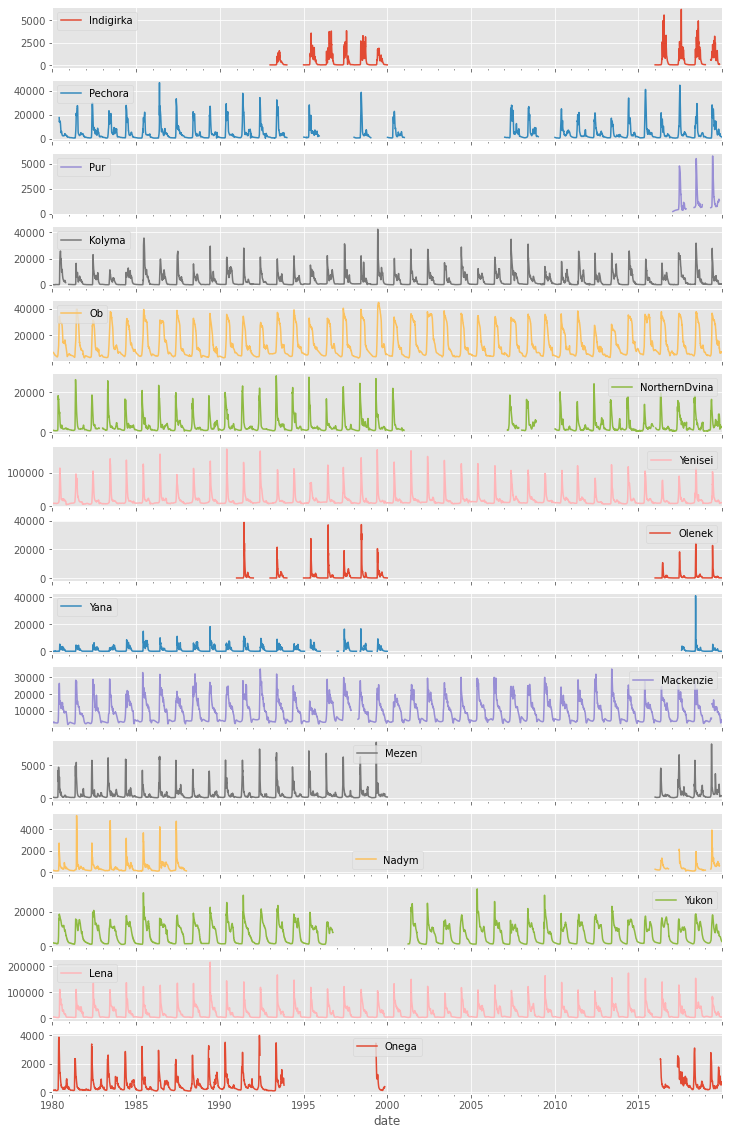

In [2]:
# Read observed data
search_path = (
    r"/home/jovyan/shared/pan_arctic_data/discharge/ArcticGRO/data/cleaned_daily/*.csv"
)
flist = glob.glob(search_path)
df_list = []
for fpath in flist:
    riv_name = os.path.split(fpath)[1].split("_")[0]
    df = pd.read_csv(fpath, parse_dates=[0])
    df.set_index("date", inplace=True)
    df.columns = [riv_name]
    df_list.append(df)
obs_df = pd.concat(df_list, axis="columns")

axes = obs_df.plot(subplots=True, figsize=(12, 20))

## 2. Identify COMID for observed catchments

Use a spatial join to assign monitoring stations in ArcticGRO to MERIT-Hydro major catchments.

In [3]:
obs_loc_csv = r"/home/jovyan/shared/pan_arctic_data/ArcticGRO_spatial_data/sampling_locations_discharge_one-site-per-river.csv"
radr_cat_shp = f"~/shared/pan_arctic_data/merit_hydro_basins/radr_cats_merged.shp"
a20_proj4_str = "+proj=stere +R=6371000.0 +lat_0=90 +lat_ts=60.0 +x_0=4180000.0 +y_0=2570000.0 +lon_0=58.0"

In [4]:
# Read MERIT-Hydro catchments used in radr
radr_cat_gdf = gpd.read_file(radr_cat_shp).to_crs(a20_proj4_str)

In [7]:
# Calculate area of radr catchments
radr_cat_gdf['area_km2'] = radr_cat_gdf.to_crs({"proj": "cea"})["geometry"].area / 1e6
radr_cat_gdf.head()

,OutCOMID,geometry,area_km2
0,25000001,"POLYGON ((3634610.187 1689218.243, 3634564.327...",202.960220
1,25000003,"POLYGON ((3591595.751 1689654.156, 3591644.174...",621.217104
2,25000008,"POLYGON ((3528052.606 1750597.746, 3528040.688...",135.043541
3,25000009,"POLYGON ((3575405.324 1703454.726, 3575518.760...",110.979211
4,25000010,"POLYGON ((3589485.791 1731352.891, 3589497.989...",115.206867


In [13]:
# Build dataframe of sampling locations
obs_loc_df = pd.read_csv(obs_loc_csv)
obs_loc_gdf = gpd.GeoDataFrame(
    obs_loc_df,
    geometry=gpd.points_from_xy(obs_loc_df["Lon"], obs_loc_df["Lat"], crs="epsg:4326"),
).to_crs(a20_proj4_str)

# Spatial join
nlocs = len(obs_loc_gdf)
obs_loc_gdf = obs_loc_gdf.sjoin(radr_cat_gdf, predicate="within")
assert nlocs == len(obs_loc_gdf)
del obs_loc_gdf["index_right"]

# Save
obs_loc_shp = r"/home/jovyan/shared/pan_arctic_data/ArcticGRO_spatial_data/sampling_locations_discharge_one-site-per-riv.shp"
obs_loc_gdf.to_file(obs_loc_shp)

obs_loc_gdf.head()

/opt/conda/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/tmp/ipykernel_141/1905641675.py:16: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  obs_loc_gdf.to_file(obs_loc_shp)


,River,Sampling_loc,Lat,Lon,Collection agency,upstream_area_E6km2,total_area_E6km2,continuous_permafrost_extent_pc,continuous_plus_discontinuous_permafrost_percent,pop_density_person_per_km2,NameTidy,geometry,OutCOMID
0,Yukon,Pilot Station,61.93,-162.88,USGS,0.83,0.83,19.0,87.0,0.2,Yukon,POINT (6124999.301 4816953.001),81020021
1,Mackenzie,Arctic Red River,67.45,-133.74,Water Survery of Canada,1.68,1.78,13.0,42.0,0.2,Mackenzie,POINT (4662256.962 4890571.113),82000867
2,Ob',Salekhard,66.63,66.60,Roshydromet,2.99,2.99,1.0,4.0,8.0,Ob,POINT (4547667.559 138911.561),31006084
3,Yenisey,Igarka,67.43,86.48,Roshydromet,2.40,2.54,31.0,42.0,3.0,Yenisei,POINT (5311240.594 484778.545),32000794
4,Lena,Kyusyur,70.68,127.39,Roshydromet,2.43,2.46,77.0,90.0,0.4,Lena,POINT (6074074.943 1857686.726),34000655


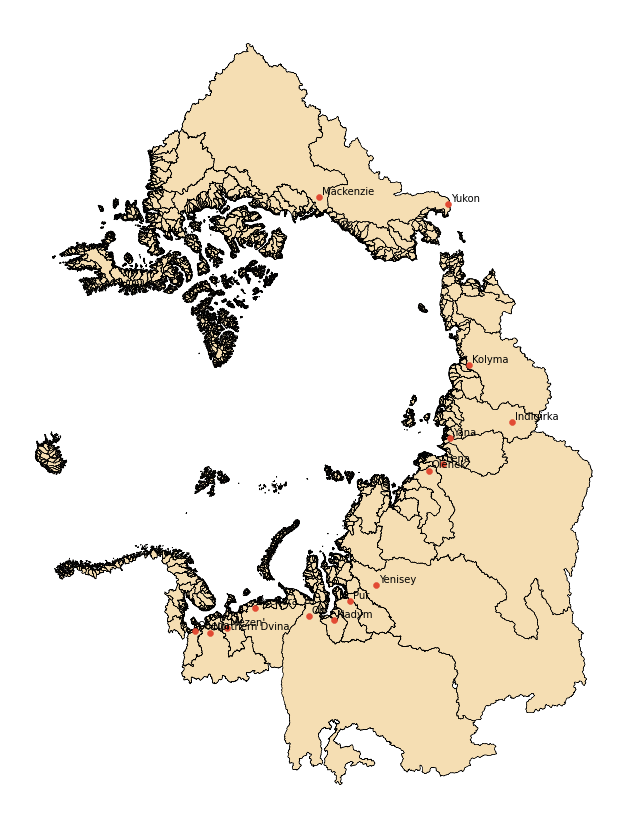

In [14]:
# Plot
ax = radr_cat_gdf.plot(figsize=(15, 15), edgecolor="k", facecolor="wheat")
obs_loc_gdf.plot(ax=ax)
for x, y, label in zip(obs_loc_gdf.geometry.x, obs_loc_gdf.geometry.y, obs_loc_gdf.River):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
ax.set_axis_off()

## 3. Get RADR data for observed catchments

Get daily modelled data from RADR for each main catchment with observations.

In [7]:
radr_path = r"/home/jovyan/shared/pan_arctic_data/discharge/RADR_v1.0.0.nc"
name_map = dict(zip(obs_loc_gdf["OutCOMID"], obs_loc_gdf["NameTidy"]))
cat_ids = obs_loc_gdf["OutCOMID"].unique()

ds = xr.open_dataset(radr_path)
ds = ds.sel(reach=cat_ids)
radr_df = ds.to_dataframe().unstack("reach")
radr_df.columns = [int(i) for i in radr_df.columns.get_level_values(1)]
radr_df.rename(name_map, inplace=True, axis="columns")
radr_df.index.name = "date"
radr_df.head()

,Yukon,Mackenzie,Ob,Yenisei,Lena,Kolyma,Onega,NorthernDvina,Mezen,Pechora,Nadym,Pur,Olenek,Yana,Indigirka
date,,,,,,,,,,,,,,,
1984-01-01,3950.173096,3378.871094,8952.445312,10851.489258,10208.205078,643.473022,86.014999,2352.587891,165.320007,3194.104980,118.849998,223.595993,351.785004,185.826996,290.862000
1984-01-02,3950.173096,3378.864990,8952.441406,10851.489258,10208.203125,643.473022,85.872002,2352.586914,165.292999,3194.104980,118.848000,223.595993,351.785004,185.826996,290.862000
1984-01-03,3899.137939,3340.862061,8870.441406,10672.846680,10062.271484,631.630981,81.374001,2327.250000,162.117996,3137.810059,117.414001,222.035995,337.123993,178.957993,278.505005
1984-01-04,3850.270996,3303.451904,8787.366211,10498.539062,9919.709961,618.999023,76.375999,2302.327881,156.447998,3082.782959,115.959999,220.453003,323.049011,172.442001,266.889008
1984-01-05,3803.260986,3266.558105,8703.269531,10328.238281,9780.322266,606.846008,72.183998,2277.069092,151.007996,3028.964111,114.487999,218.835999,309.561005,166.264999,255.964005


In [16]:
radr_df.to_csv(r"/home/jovyan/shared/pan_arctic_data/discharge/radr_for_arctic-gro_catchments.csv")

## 4. Join RADR daily modelled data to observations and save

In [11]:
obs_df_long = obs_df.reset_index().melt(
    id_vars=["date"], var_name="site", value_name="q_m3ps"
)
radr_df_long = radr_df.reset_index().melt(
    id_vars=["date"], var_name="site", value_name="q_m3ps"
)
df = pd.merge(
    obs_df_long,
    radr_df_long,
    how="inner",
    on=["date", "site"],
    suffixes=["_obs", "_radr"],
)
df["month"] = df["date"].dt.month
df.dropna(how="any", inplace=True)

df.to_csv(r"/home/jovyan/shared/pan_arctic_data/discharge/RADR_vs_ArcticGRO.csv")
df.head()

,date,site,q_m3ps_obs,q_m3ps_radr,month
3288,1993-01-01,Indigirka,4.62,79.848000,1
3289,1993-01-02,Indigirka,4.48,78.029999,1
3290,1993-01-03,Indigirka,4.34,76.291000,1
3291,1993-01-04,Indigirka,4.20,74.625000,1
3292,1993-01-05,Indigirka,4.06,73.028999,1
